# Recognizing hand-written digits using neural network

**Outline**

* [Intro](#intro)
* [Basic Concepts to understand deep learning](#concepts)
* [1 layer neural network using Keras](#1nn_keras)
    * [Model Building](#keras_model)
    * [Make Prediction](#keras_predict)    
* [1 layer neural network using Sklearn](#1nn_sklearn)
    * [Parameter Tuning](#tune)
    * [Make Prediction](#sklearn_predict)  
* [Side Note for activation function](#activation)    
* [Reference](#refer)        

---

In [3]:
%matplotlib inline
# basic setup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import mnist
np.random.seed(0)

# model related
import keras.utils.np_utils as np_utils
import keras.models as models, keras.layers.core as layers, keras.optimizers

Using TensorFlow backend.


## <a id='intro'>Intro</a>

For almost every begineer of deep learning, the first "Hello world" example is to recognizing hand-written digits using the MNIST database. It includes handwritten digits from 0 to 9 and has a training set of 60,000 examples, and a test set of 10,000 examples. It is a subset of a larger set available from NIST. The digits have been size-normalized and centered in a fixed-size image. In this notebook, we will be using this data set to get a sense of building deep learing model using keras.

## <a id='concepts'>Basic Concepts to understand deep learning</a>

### **Important Concepts**

Good weights are the key to good predictions. There are three concepts to understand how a model gets good weights. Those are

* Loss Function
* Gradient Descent
* Back Propagations

> **Loss Function**

the loss function of a logistic regression is log likelihood. The larger the value is, the better the model is. 

In Scikit-learn has a conventin in its metrics that lower scores are better. So, scikit-learn report -1 * log loss / num_observations. The division by the number of datapoints is used so the range of values doesn't systematically vary with the dataset size.

The function's input is actual and predicted value. If the predicted values are close to the actual values, then the loss function will output a small value; if the predicted values are far off, the function will return a high value.

> **Gradient Descent**

The input of the loss function is actual and predicted value. We also know that the predicted value is the output of the model itself with some weights. Therefore, we can get the value of our loss function by changing the weight, i.e., some parameters, of the model. The goal is to find the weight that can generate us the best, i.e., the lowest value for the loss function. Gradient descent is a method that can help us get those weight. For a more detailed illustration about gradient descent as well as stochastic gradient descent, please see this [post](https://nbviewer.jupyter.org/github/johnnychiuchiu/Machine-Learning/blob/master/OptimizationMethod/gradientDescent.ipynb).

Generally, we don't use all of our data to calculate each step in gradient descent, since doing so would require a lot of calculations and it'll be slow. Instead, we use a batch of data point or just a single data point. That is basically what batch gradient descent and stochastic gradient descent are. 

1 time through the data is called an epoch. We incrementally improve weight from multiple epochs, so each image will be used to improve weights more than once. We set the number of epochs as a parameter into the fit command as we have seen above. We can set the batch size in the ImageDataGenerator function as well.

The size of the weight changes is determined by something called the learning rate. Low learning rate means that our model may take a long time training before it gets accurate. High learning rate means that our model may take hugh steps around in that field, and it may result in jumping over the best weights. 

> **Backward Propagation**

How do we find which way we can change the weights to improve the loss function? Basically, how do we see which way goes downhill? That is what backward propagation does.

More specifically, suppose we have only one parameters with a bell shape curve. It is pretty straight forward for us to know which way to go downhill of the loss function. We can do it by simply take a partial derivative of that parameter. However, since neural network is a combination of a lots of activation function, for example, logistic function or ReLu. We can think of neural network as function of many other function. If we want to know whether if the partial derivative of a particular data point is positive or negative, we'll need to take the partial derivative of the outer most function. Then by chain rule, we'll need to know the partial derivative of the 1-step ahead inner function...etc. I think this is the idea of backward propagation.

In short, backward propagation is a process by which we use to find out which way to change the weights at each step of gradient descent.

<img src="pic/loss.png" style="width: 600px;height: 450px;"/>

### Number of parameters for a single layer neural network

Suppose, 

* There are k features in the model
* The number of node in the hidden layer is M
* The number of output is 1 for regression neural network

For each node, we will need $k+1$ parameters, and there are M nodes. Therefore, in the input to hidden layer, we'll need $M \times (k+1)$ parameters.

From hidden to output layer, we will need $M+1$ parameters.

Totally, we need $M \times (k+1) + (M + 1)$ parameters to fit this neural network model.

<img src="pic/1nn.png" style="width: 600px;height: 450px;"/>

### Steps to fit a neural network model

1. Standardize predictors. Due to the high flexibility of the model, it is very easy to overfit the data. To solve this, we add a regularization term in the cost function. We want to standardize our features before fitting the model since we want to give the same shrinkage weight to all the predictors. If we don’t scale it, the predictor with larger range will shrink more. In other words, the weight of shrink will be different.

2. Standard the response. For a prediction problem the model is learning an approximation of the function between the input and output data. Commonly this is done through gradient descent which relies on calculation of the error between predictions and true values for each instance. Now obviously your gradient descent wont work if your model output is constrained to a range of values by your activation function (such as Sigmoid with range [0, 1]) which your real output values fall outside of. 

3. choose
    * hidden layers 
    * nodes in each hidden layer
    * output activation function (usually linear or logistic)
    * other options and tuning parameters (e.g. $\lambda$)

4. Software estimates parameters to minimize (nonlinear LS with shrinkage):

    $$\sum_{i=1}^{n}\Big[y_i - g(x_i, \theta)  \Big]^2 + \lambda \Big(\sum_{m=1}^{M}\sum_{j=0}^{k}\alpha_{m,j}^2 +\sum_{m=0}^{M}\beta_m^2 \Big)$$

5. For making prediction: when you reach the last layer (the output neuron(s)), what you get is again another activation between -1 and 1. You have to convert this back into a value for the house in question, whether that value will be used as a prediction in a test set or to calculate error during training. However you do this, you just have to be consistent and use the same de-normalization procedure in training and testing.

![](pic/1nn.jpg)

## <a id='1nn_keras'>1 layer neural network using Keras</a>

### **Read Data**

In [16]:
# load dataset from keras datasets
(X_train, Y_train), (X_test, Y_test) = keras.datasets.mnist.load_data() 

# reshape a 2D array (28, 28) into a vector (784, )
# -1 means that it will figure out the length of another dimension automatically
X_train = X_train.reshape(-1, 784) 
X_test = X_test.reshape(-1, 784)

# constrant the values in the array within [0,1]
X_train = X_train.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0 

# one-hot encoding to the response variable
Y_train = np_utils.to_categorical(Y_train, 10)
Y_test = np_utils.to_categorical(Y_test, 10)

### <a id='keras_model'>Build 1 layer neural network model</a>

In [17]:
# create a nn model
model = models.Sequential() 

# first layer, input is 784 dim with 128 nodes
model.add(layers.Dense(units=128, input_dim=784)) 

# the activation function is sigmoid
model.add(layers.Activation('sigmoid')) 

# the number of output category is with 10
model.add(layers.Dense(units=10)) 

# output prob calculation function
model.add(layers.Activation('softmax'))

In [22]:
model.compile(loss='categorical_crossentropy', optimizer='sgd')  #keras.optimizers.RMSprop()
model.fit(X_train, Y_train, batch_size=128, epochs=20, verbose=2)

Epoch 1/20
 - 1s - loss: 0.0320
Epoch 2/20
 - 1s - loss: 0.0316
Epoch 3/20
 - 1s - loss: 0.0314
Epoch 4/20
 - 1s - loss: 0.0313
Epoch 5/20
 - 1s - loss: 0.0312
Epoch 6/20
 - 1s - loss: 0.0312
Epoch 7/20
 - 1s - loss: 0.0311
Epoch 8/20
 - 1s - loss: 0.0310
Epoch 9/20
 - 1s - loss: 0.0310
Epoch 10/20
 - 1s - loss: 0.0309
Epoch 11/20
 - 1s - loss: 0.0309
Epoch 12/20
 - 1s - loss: 0.0308
Epoch 13/20
 - 1s - loss: 0.0308
Epoch 14/20
 - 1s - loss: 0.0307
Epoch 15/20
 - 1s - loss: 0.0307
Epoch 16/20
 - 1s - loss: 0.0307
Epoch 17/20
 - 1s - loss: 0.0306
Epoch 18/20
 - 1s - loss: 0.0306
Epoch 19/20
 - 1s - loss: 0.0305
Epoch 20/20
 - 1s - loss: 0.0305


### <a id='keras_predict'>Make Prediction</a>

In [23]:
predictions = model.predict(X_test) 

### **Evaluate using overall training accuracy**

In [27]:
def test_accuracy_1nn(predictions, X_test, Y_test):
    ncorrect = 0
    i=0    
    for (ex, cls) in zip(X_test, Y_test):
        if np.argmax(cls) == np.argmax(predictions[i]):
            ncorrect += 1
        i = i+1   
    print("Test accuracy: %d/%d = %0.2f %%" % (ncorrect, len(Y_test), 100.0*ncorrect/len(Y_test)))    

In [28]:
test_accuracy_1nn(predictions, X_test, Y_test)

Test accuracy: 9772/10000 = 97.72 %


As shown above, the overall accuracy using 1 layer neural network is 97.72%, which is quite high.

### **Let's also plot out the image and the result to get a better sense of it**

Prediction: 7
Probability: 0.999656


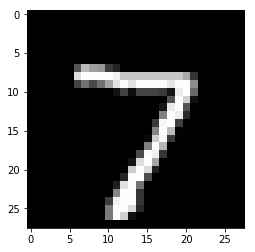

--------------------------------------
Prediction: 2
Probability: 0.999811


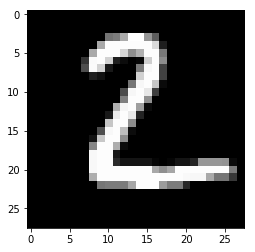

--------------------------------------
Prediction: 1
Probability: 0.998948


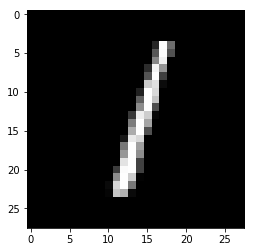

--------------------------------------
Prediction: 0
Probability: 0.999795


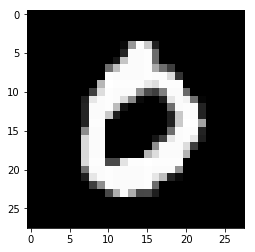

--------------------------------------
Prediction: 4
Probability: 0.997996


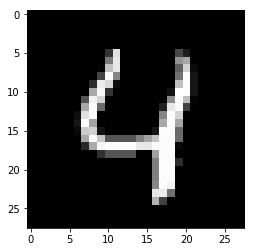

--------------------------------------
Prediction: 1
Probability: 0.998364


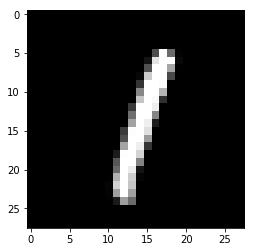

--------------------------------------
Prediction: 4
Probability: 0.999793


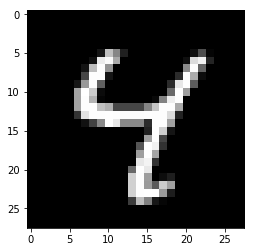

--------------------------------------
Prediction: 9
Probability: 0.99955


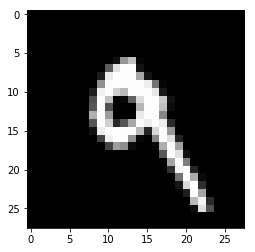

--------------------------------------
Prediction: 6
Probability: 0.500208


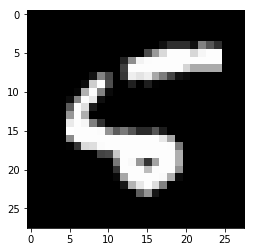

--------------------------------------
Prediction: 9
Probability: 0.991316


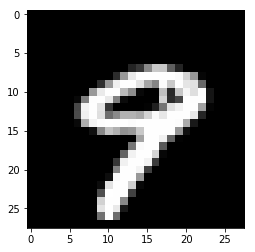

--------------------------------------


In [39]:
for i in range(10):
    plt.imshow(np.reshape(X_test[i], (28, 28)), cmap='gray') 
    print("Prediction:", np.argmax(predictions[i])) 
    print("Probability:", predictions[i][np.argmax(predictions[i])])     
    plt.show()
    print("--------------------------------------")

---

## <a id="1nn_sklearn">1 layer neural network using Sklearn</a>

In [40]:
%matplotlib inline

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn import model_selection
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import scale

from sklearn.metrics import classification_report

SEED = 12345

In [41]:
def fit_nn(x, y, param_setting={}, fold=5, seed=SEED):
    """Neural Network for Classification, get the CV AUC"""        
    
   # set seed and default parameter 
    params_default = {'random_state':seed,
                     'activation': 'logistic',
                     }

    # update the input parameters
    params = dict(params_default)
    params.update(param_setting)
    
    seed= SEED        
    kfold = model_selection.KFold(n_splits=fold, random_state=seed)
    model = MLPClassifier(**params)    
    
    results = model_selection.cross_val_score(model, x, y, cv=kfold, scoring='roc_auc')
    print(results.mean())
    
    model.fit(x, y)
    
    return model

In [42]:
param_setting={'max_iter':2000, 'early_stopping':True, 'learning_rate_init':0.01}
nn_base = fit_nn(X_train, Y_train, fold=5, param_setting=param_setting, seed=SEED)

0.998000470515


In [43]:
nn_base

MLPClassifier(activation='logistic', alpha=0.0001, batch_size='auto',
       beta_1=0.9, beta_2=0.999, early_stopping=True, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.01, max_iter=2000, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=12345,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False)

### <a id="tune">Parameter Tuning </a>

**Steps**
1. Use logistics activation function for 1 hidden layer neural network
2. Tune the model using combination of node in the hidden layer and alpha and pick the best parameters.

**Key parameters**

* **hidden_layer_sizes**: The ith element represents the number of neurons in the ith hidden layer. length = n_layers - 2. Default is (100,), which means that there is only 1 hidden layer with 100 nodes, since len((100,))=1=3-2. 3 means that there are 3 layers including input and output layer. For architecture 56:25:11:7:5:3:1 with input 56 and 1 output hidden layers will be (25:11:7:5:3). So tuple hidden_layer_sizes = (25,11,7,5,3,)
* **alpha**: L2 penalty (regularization term) parameter.

In [45]:
def parameter_tuning(model, X_train, y_train, param_grid, fold=5):   
    """
    Tune a tree based model using GridSearch, and return a model object with an updated parameters
    
    Parameters
    ----------
    model: sklearn's ensemble tree model
        the model we want to do the hyperparameter tuning.
    
    X_train: pandas DataFrame
        Preprocessed training data. Note that all the columns should be in numeric format.
    
    y_train: pandas Series
    
    param_grid: dict
        contains all the parameters that we want to tune for the responding model.    
        

    Note
    ----------
    * we use kfold in GridSearchCV in order to make sure the CV Score is consistent with the score 
      that we get from all the other function, including fit_bagging, fit_randomforest and fit_gbm. 
    * We use model_selection.KFold with fixed seed in order to make sure GridSearchCV uses the same seed as model_selection.cross_val_score.
    
    """
    seed=SEED
    
#     if 'n_estimators' in param_grid:
#         model.set_params(warm_start=True) 
    
    kfold = model_selection.KFold(n_splits=fold, random_state=seed)
    gs_model = GridSearchCV(model, param_grid, cv=kfold, scoring='roc_auc')
    gs_model.fit(X_train, y_train)
    
    # best hyperparameter setting
    print('best parameters:{}'.format(gs_model.best_params_)) 
    print('best score:{}'.format(gs_model.best_score_)) 
    
    # refit model on best parameters
    model.set_params(**gs_model.best_params_)
    model.fit(X_train, y_train)

    return(model)

> **Set Default Parameter**

In [46]:
params = {
    'max_iter':2000, 
    'early_stopping':True, 
    'learning_rate_init':0.01,
    'random_state':SEED
}

nn = MLPClassifier(**params)

> **Set Tuning Parameter**

In [51]:
param_grid_nn_1 = {
    'hidden_layer_sizes': [(100,), (150,)],
    'alpha': [0.001, 0.01],
}

In [52]:
nn_2 = parameter_tuning(nn, X_train, Y_train, param_grid_nn_1)

best parameters:{'alpha': 0.001, 'hidden_layer_sizes': (150,)}
best score:0.9985582993460546


In [53]:
nn_2

MLPClassifier(activation='relu', alpha=0.001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=True, epsilon=1e-08,
       hidden_layer_sizes=(150,), learning_rate='constant',
       learning_rate_init=0.01, max_iter=2000, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=12345,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False)

> **Get Cross Validation Accuracy**

In [ ]:
def get_cv_score(model, x, y, fold=5, scoring='accuracy', seed=SEED):
    """Get the cv score for a fitted model"""
    
    kfold = model_selection.KFold(n_splits=fold, random_state=seed)
    results = model_selection.cross_val_score(model, x, y, cv=kfold, scoring=scoring)
    print(results.mean())
    
    return results

In [56]:
# get the mean accuracy.
get_cv_score(nn_2, X_train, Y_train, fold=5, scoring='accuracy', seed=SEED)

0.946133333333


array([ 0.94633333,  0.94366667,  0.94383333,  0.94266667,  0.95416667])

### <a id='sklearn_predict'>Make Prediction</a>

plot out the image and the result to get a better sense of it

In [60]:
predictions_sklearn = nn_2.predict_proba(X_test) 

Prediction: 7
Probability: 0.999860723018


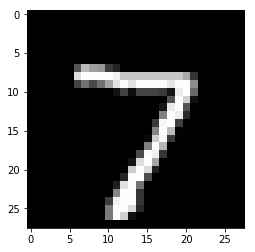

--------------------------------------
Prediction: 2
Probability: 0.996602426925


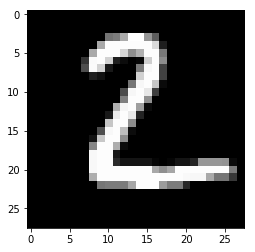

--------------------------------------
Prediction: 1
Probability: 0.989897747128


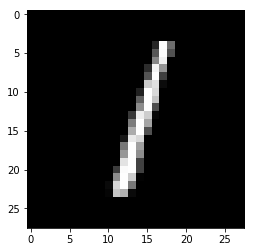

--------------------------------------
Prediction: 0
Probability: 0.999998336198


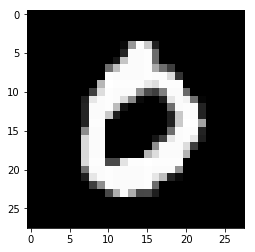

--------------------------------------
Prediction: 4
Probability: 0.998982994314


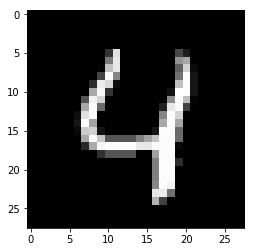

--------------------------------------
Prediction: 1
Probability: 0.999762614805


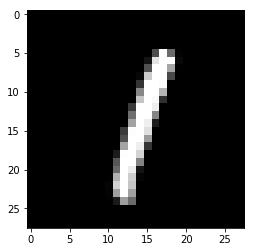

--------------------------------------
Prediction: 4
Probability: 0.996917944033


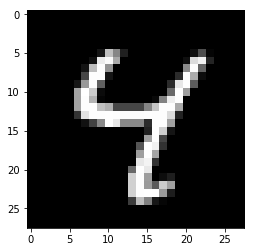

--------------------------------------
Prediction: 9
Probability: 0.984984191503


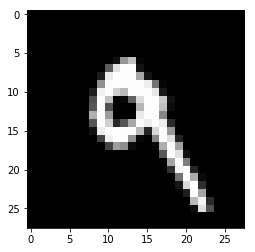

--------------------------------------
Prediction: 4
Probability: 0.312927489256


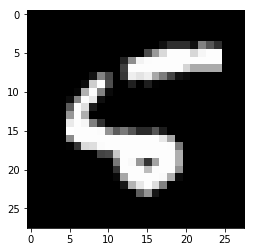

--------------------------------------
Prediction: 9
Probability: 0.982375349388


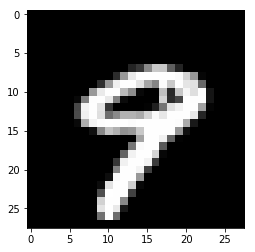

--------------------------------------


In [62]:
for i in range(10):
    plt.imshow(np.reshape(X_test[i], (28, 28)), cmap='gray') 
    print("Prediction:", np.argmax(predictions_sklearn[i])) 
    print("Probability:", predictions_sklearn[i][np.argmax(predictions_sklearn[i])])     
    plt.show()
    print("--------------------------------------")

### <a id='activation'>Side note for Activation Function</a>

> **What is activation function?**

The function help to decide whether each neuron should be activated or not and adding non-linearity to the networks. See more on [Understanding Activation Functions in Neural Networks](https://medium.com/the-theory-of-everything/understanding-activation-functions-in-neural-networks-9491262884e0)

> **Why do we use ReLU replacing Sigmoid?**

The gradient of the sigmoid is close to 0 when the x is large positive or very negative. It means that when we try to update the weight, the update is very small. It takes a long time to run. Even when the value of the data point is big, when it times the gradient, the result will be still small. 

That's why we need ReLU. The gradient of ReLU will not be close to 0 when x is large positive or very negative. When we use ReLU as activation function, the larger derivative (or gradient) or it can help us update the weight more efficiently than using the sigmoid function. 

The pros of using ReLu is that we can train the model more efficiently. If we have enough time, the result of using sigmoid and ReLU will be the same. 

When we do the back propagation, what we really calculate is the derivative of the activation function. The parameters of the activation is the things that we have control of. That's where the difference of using ReLU and Sigmoid function from.

[Why do we use ReLU in neural networks and how do we use it?](https://stats.stackexchange.com/questions/226923/why-do-we-use-relu-in-neural-networks-and-how-do-we-use-it)

Gradients of logistic and hyperbolic tangent networks are smaller than the positive portion of the ReLU. This means that the positive portion is updated more rapidly as training progresses. However, this comes at a cost. The 0 gradient on the left-hand side is has its own problem, called "dead neurons," in which a gradient update sets the incoming values to a ReLU such that the output is always zero; modified ReLU units such as ELU (or Leaky ReLU etc.) can minimize this.


## <a id="refer">Reference</a>

* [sklearn MLPClassifier](http://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html#sklearn.neural_network.MLPClassifier)
* [sklearn scale](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.scale.html)
* [Stackoverflow: hidden_layer_sizes](https://stackoverflow.com/questions/35363530/python-scikit-learn-mlpclassifier-hidden-layer-sizes)
* [Adam Optimization](https://machinelearningmastery.com/adam-optimization-algorithm-for-deep-learning/)
* [sklearn: scoring parameter](http://scikit-learn.org/0.15/modules/model_evaluation.html)